In [1]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import matplotlib.path as mpath

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np

from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr

from cdo import Cdo
cdo = Cdo()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

In [5]:
pip show tensorflow

Name: tensorflow
Version: 2.9.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/mpyrina/.local/lib/python3.8/site-packages
Requires: h5py, keras-preprocessing, tensorflow-io-gcs-filesystem, six, packaging, tensorflow-estimator, numpy, typing-extensions, astunparse, google-pasta, setuptools, termcolor, protobuf, gast, wrapt, absl-py, tensorboard, libclang, grpcio, keras, opt-einsum, flatbuffers
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

2022-08-19 13:23:10.733320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-19 13:23:10.733352: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data sets

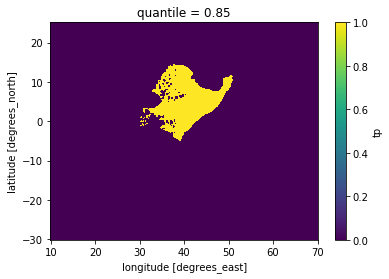

In [7]:
#Check the regional mask
root_data='/data/volume_2/observational/'
root_results='/home/mpyrina/Lorentz_workshop/Results/'

file='era5_hoa_dry_mask_0.25deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,combine='by_coords',parallel=True)
mask.tp.plot()

Frozen(SortedKeysDict({'latitude': 28, 'longitude': 31}))

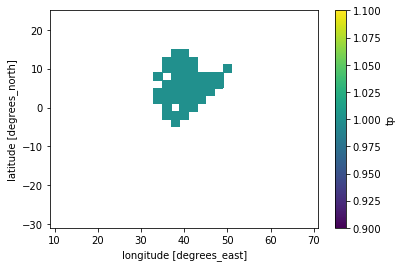

In [9]:
#Check the regional mask
root_data='/data/volume_2/observational/'
root_results='/home/mpyrina/Lorentz_workshop/Results/'

file='era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values==1 and mask the rest
mask_nan.tp.plot()
mask_nan.sizes

In [89]:
# Create time series of predictor data for the area_mean

file=xr.open_mfdataset(root_data+f'/raw/era5_tp_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
tp_dim=file.sel(longitude=slice(10,70),latitude=slice(24,-30))
tp_series=np.multiply(mask_nan,tp_dim).mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# Calculate daily terciles based on a 31 day rolling
tp_rol=tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.year.isin([np.arange(2000,2021)]))
tp_group=tp_rol.sel(time=tp_rol.time.dt.month.isin([10,11,12])).quantile(0.33)

In [93]:
#MAsk the time series with the percentile and create index time series
tp_rol=tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_index=tp_rol.where(tp_rol<tp_group['tp'].values)

tp_index_1=tp_index['tp'].values
tp_index_1[np.where(~np.isnan(tp_index_1))]=1
tp_index_1[np.where(np.isnan(tp_index_1))]=0
tp_ind_1=np.where((tp_index['tp'].values)==np.isnan,1,0)
np.unique(tp_index_1,return_counts=True)

/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(array([0., 1.]), array([4025, 1771]))

In [96]:
# TP Predictor

tp_predictor=tp_series.sel(time=tp_series.time.dt.year.isin([np.arange(1980,2021)])).rolling(time=7, center=True).mean()

In [97]:
tp_predictor

<xarray.Dataset>
Dimensions:  (time: 14976)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2020-12-31
Data variables:
    tp       (time) float64 dask.array<chunksize=(14976,), meta=np.ndarray>

In [ ]:
#create index for predicting October 1st

(array([0., 1.]), array([4025, 1771]))

In [88]:
np.unique(tp_index_1,return_counts=True)



(array([0., 1.]), array([3339, 2457]))

In [ ]:
#Calculate anomalies 
clim = obs_mean.groupby('time.dayofyear').mean('time').load()
anom = (obs_mean.groupby('time.dayofyear') - clim)
anom_sm= anom.rolling(time=7, center=True).mean().dropna("time")
print(anom.sizes)
print(anom_sm.sizes)

## LSTM with attention layer

In [7]:
# https://github.com/gentaiscool/lstm-attention/blob/58adc7e345b5b3a79638483049704802a66aa1f4/layers.py#

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    follows these equations:
    
    (1) u_t = tanh(W h_t + b)
    (2) \alpha_t = \frac{exp(u^T u)}{\sum_t(exp(u_t^T u))}, this is the attention weight
    (3) v_t = \alpha_t * h_t, v in time t
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        3D tensor with shape: `(samples, steps, features)`.
    """

    def __init__(self,
                W_regularizer=None, u_regularizer=None, b_regularizer=None,
                W_constraint=None, u_constraint=None, b_constraint=None,
                bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                initializer=self.init,
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zero',
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero and this results in NaN's. 
        # Should add a small epsilon as the workaround
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        
        return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]
    
class Addition(Layer):
    """
    This layer is supposed to add of all activation weight.
    We split this from AttentionWithContext to help us getting the activation weights
    follows this equation:
    (1) v = \sum_t(\alpha_t * h_t)
    
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """

    def __init__(self, **kwargs):
        super(Addition, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[-1]
        super(Addition, self).build(input_shape)

    def call(self, x):
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [8]:
# LSTM with attention layer
mlen = 40
mdim = 2000
input_tensor = Input(shape=(mlen,mdim))
layer1 = layers.LSTM(10, return_sequences=True, kernel_regularizer=regularizers.l2(25))(input_tensor)
layer1 = layers.LSTM(10, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(layer1)
layer1 = AttentionWithContext()(layer1)
layer1 = Addition()(layer1)
layer1 = layers.Dense(10, activation="relu")(layer1)
output_tensor = layers.Dense(2,activation='softmax')(layer1)

callbacks_path = '/net/cfc/s2s/zhengwu/code/tmp/checkpoint_test'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=callbacks_path,
        monitor='val_acc',
        save_best_only=True,
    )
]
model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

2022-08-19 07:58:41.832626: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-19 07:58:41.832665: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyternb): /proc/driver/nvidia/version does not exist
2022-08-19 07:58:41.835256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2000)]        0         
                                                                 
 lstm (LSTM)                 (None, 40, 10)            80440     
                                                                 
 lstm_1 (LSTM)               (None, 40, 10)            840       
                                                                 
 attention_with_context (Att  (None, 40, 10)           120       
 entionWithContext)                                              
                                                                 
 addition (Addition)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 10)                110       
                                                             

In [9]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_validation, Y_validation))

NameError: name 'X_train' is not defined

In [ ]:
# output attention weights 
layer_weights = model.layers[3].get_weights()

# extract layer output before the attention layer
new_model = Model(inputs=model.input, outputs=model.layers[2].output)
output_before_att = new_model.predict(X_validation)
print(type(output_before_att),np.shape(output_before_att))

# weights from Yang et al. (2016) HAN
uit = np.tanh(np.dot(output_before_att, layer_weights[0]) + layer_weights[1]) 
eij = np.dot(uit, layer_weights[2])
print(uit.shape,eij.shape)
eij = eij.reshape((eij.shape[0], eij.shape[1]))
print(eij.shape)
ai = np.exp(eij)
weights = np.ndarray((len(ai),mlen))+np.nan
for ii in range(len(ai)):
    weights[ii,:] = ai[ii,:] / np.sum(ai[ii,:])
print(ai.shape,weights.shape)

In [ ]:
weights_norm = weights/np.nanmax(weights, axis=(-1))[:,np.newaxis]
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
for ii in range(len(weights)):
    plt.plot(weights[ii,:]*30)

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(np.mean(weights,axis=0))

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(np.mean(weights,axis=0)/np.nanmax(np.mean(weights,axis=0)),'k',linewidth=2)